In [1]:
ENV["JULIA_PKG_SERVER"] = ""

using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using ScientificTypes
using TableTransforms
using CSV

  Activating project at `~/Documents/GitHub/Imbalance.jl/examples`


### 1. Generate Random Data

Let's start by generating some random imbalanced data. Here we generate data where there are three classes `0, 1, 2` that occur with probability `0.5, 0.2, 0.3` respectively, making `0` the majority class. The data has `4` continuous features and `4` categorical features where the categorical variables have `3, 4, 2, 5` unique values respectively.

In [2]:
rng = Random.default_rng()

num_rows = 100
num_cont_feats = 4
class_probs = [0.5, 0.2, 0.3]

num_vals_per_category = [3, 4, 2, 5]

X, y = generate_imbalanced_data(num_rows, num_cont_feats; class_probs, num_vals_per_category)
X = DataFrame(X)

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.416,0.345,0.44,0.337,1.0,2.0,2.0,2.0
2,0.368,0.558,0.468,0.903,1.0,2.0,1.0,3.0
3,0.541,1.352,0.023,0.852,2.0,4.0,2.0,4.0
4,0.378,0.086,0.265,0.234,1.0,1.0,2.0,5.0
5,1.153,0.375,0.318,1.368,1.0,3.0,1.0,2.0
6,0.405,0.621,0.405,0.371,2.0,4.0,1.0,4.0
7,1.089,1.119,0.151,1.086,2.0,4.0,1.0,4.0
8,0.414,0.556,0.482,0.16,1.0,1.0,1.0,4.0
9,0.742,1.05,-0.024,0.682,1.0,4.0,1.0,3.0


We follow by coercing the columns with few values (i.e., the categorical ones) to the appropriate type (a finite `sci-type` such as `OrderedFactor` or `Multiclass`). This is necessary because the `SMOTE-NC` assumes that all categorical features have `sci-type` finite.

In [3]:
X = coerce(X, autotype(X, :few_to_finite))

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…
1,0.416,0.345,0.44,0.337,1.0,2.0,2.0,2.0
2,0.368,0.558,0.468,0.903,1.0,2.0,1.0,3.0
3,0.541,1.352,0.023,0.852,2.0,4.0,2.0,4.0
4,0.378,0.086,0.265,0.234,1.0,1.0,2.0,5.0
5,1.153,0.375,0.318,1.368,1.0,3.0,1.0,2.0
6,0.405,0.621,0.405,0.371,2.0,4.0,1.0,4.0
7,1.089,1.119,0.151,1.086,2.0,4.0,1.0,4.0
8,0.414,0.556,0.482,0.16,1.0,1.0,1.0,4.0
9,0.742,1.05,-0.024,0.682,1.0,4.0,1.0,3.0


### 2. Apply SMOTE-NC

#### Using Imbalance Only

Applying SMOTE-NC using the standard API is very straightforward. There are two main hyperparameters which are the number of nearest neighbors `k` and the wanted ratios of each class relative to the majority class `ratios`. In the example below, we want all three classes to have `120%` of the data that was present in the majority class (i.e., class `0` prior to applying the algorithm)

In [4]:
Xover, yover = smotenc(X, y; k = 5, ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng = 42)

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01



Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
  class:  2


(186×8 DataFrame
 Row │ Column1  Column2    Column3    Column4  Column5  Column6  Column7  Colu ⋯
     │ Float64  Float64    Float64    Float64  Cat…     Cat…     Cat…     Cat… ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.416    0.345       0.44      0.337    1.0      2.0      2.0      2.0  ⋯
   2 │ 0.368    0.558       0.468     0.903    1.0      2.0      1.0      3.0
   3 │ 0.541    1.352       0.023     0.852    2.0      4.0      2.0      4.0
   4 │ 0.378    0.086       0.265     0.234    1.0      1.0      2.0      5.0
   5 │ 1.153    0.375       0.318     1.368    1.0      3.0      1.0      2.0  ⋯
   6 │ 0.405    0.621       0.405     0.371    2.0      4.0      1.0      4.0
   7 │ 1.089    1.119       0.151     1.086    2.0      4.0      1.0      4.0
   8 │ 0.414    0.556       0.482     0.16     1.0      1.0      1.0      4.0
  ⋮  │    ⋮         ⋮          ⋮         ⋮        ⋮        ⋮        ⋮        ⋮ ⋱
 180 │ 1.17755  0.0908712   0

#### Using MLJ

To use `MLJ`, we first instantiate the model using keyword parameters, wrap it in a machine and the transform the machine with our input data `X,y`.

In [5]:
smotenc_model = Imbalance.MLJ.SMOTENC(k=5, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
mach = machine(smotenc_model)
Xover, yover = transform(mach, X, y)

(186×8 DataFrame
 Row │ Column1  Column2    Column3    Column4  Column5  Column6  Column7  Colu ⋯
     │ Float64  Float64    Float64    Float64  Cat…     Cat…     Cat…     Cat… ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.416    0.345       0.44      0.337    1.0      2.0      2.0      2.0  ⋯
   2 │ 0.368    0.558       0.468     0.903    1.0      2.0      1.0      3.0
   3 │ 0.541    1.352       0.023     0.852    2.0      4.0      2.0      4.0
   4 │ 0.378    0.086       0.265     0.234    1.0      1.0      2.0      5.0
   5 │ 1.153    0.375       0.318     1.368    1.0      3.0      1.0      2.0  ⋯
   6 │ 0.405    0.621       0.405     0.371    2.0      4.0      1.0      4.0
   7 │ 1.089    1.119       0.151     1.086    2.0      4.0      1.0      4.0
   8 │ 0.414    0.556       0.482     0.16     1.0      1.0      1.0      4.0
  ⋮  │    ⋮         ⋮          ⋮         ⋮        ⋮        ⋮        ⋮        ⋮ ⋱
 180 │ 1.17755  0.0908712   0

#### Using TableTransforms

Let's consider an example with table transforms on a more realistic dataset. This time the categorical variables are strings so all we had to do is coerce `strings`to the `multiclass` type. `smotenc` will take of encoding them and decoding them before and after applying the actual algorithm.

In [6]:
# For TableTransforms
Xy = CSV.read("./datasets/churn.csv", DataFrame)
y_ind = 17
Xy = coerce(Xy, autotype(Xy, :string_to_multiclass))

Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Int64,Int64,Cat…,Int64,Cat…,Cat…,Int64,Int64,Float64,Int64,Int64,Int64,Float64,Int64
1,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,1.01349e5,1
2,2,15647311,Hill,608,Spain,Female,41,1,83807.9,1,0,1,1.12543e5,0
3,3,15619304,Onio,502,France,Female,42,8,1.59661e5,3,1,0,1.13932e5,1
4,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.6,0
5,5,15737888,Mitchell,850,Spain,Female,43,2,1.25511e5,1,1,1,79084.1,0
6,6,15574012,Chu,645,Spain,Male,44,8,1.13756e5,2,1,0,1.49757e5,1
7,7,15592531,Bartlett,822,France,Male,50,7,0.0,2,1,1,10062.8,0
8,8,15656148,Obinna,376,Germany,Female,29,4,1.15047e5,4,1,0,1.19347e5,1
9,9,15792365,He,501,France,Male,44,4,1.42051e5,2,0,1,74940.5,0


Now we instantiate the model and simply pass the data to it using the pipeline operator `\>`. This is equivalent to calling `apply` from table transforms.

In [10]:
using Imbalance: TableTransforms.SMOTENC
y_ind = 14
smote_model_t = SMOTENC(y_ind, knn_tree="Ball", ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> smote_model_t

Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Float64,Float64,Cat…,Float64,Cat…,Cat…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.56346e7,Hargrave,619.0,France,Female,42.0,2.0,0.0,1.0,1.0,1.0,1.01349e5,1.0
2,2.0,1.56473e7,Hill,608.0,Spain,Female,41.0,1.0,83807.9,1.0,0.0,1.0,1.12543e5,0.0
3,3.0,1.56193e7,Onio,502.0,France,Female,42.0,8.0,1.59661e5,3.0,1.0,0.0,1.13932e5,1.0
4,4.0,1.57014e7,Boni,699.0,France,Female,39.0,1.0,0.0,2.0,0.0,0.0,93826.6,0.0
5,5.0,1.57379e7,Mitchell,850.0,Spain,Female,43.0,2.0,1.25511e5,1.0,1.0,1.0,79084.1,0.0
6,6.0,1.5574e7,Chu,645.0,Spain,Male,44.0,8.0,1.13756e5,2.0,1.0,0.0,1.49757e5,1.0
7,7.0,1.55925e7,Bartlett,822.0,France,Male,50.0,7.0,0.0,2.0,1.0,1.0,10062.8,0.0
8,8.0,1.56561e7,Obinna,376.0,Germany,Female,29.0,4.0,1.15047e5,4.0,1.0,0.0,1.19347e5,1.0
9,9.0,1.57924e7,He,501.0,France,Male,44.0,4.0,1.42051e5,2.0,0.0,1.0,74940.5,0.0


In [8]:
smote_model_t = SMOTENC(5, ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> smote_model_t

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:15



Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
  class:  2.0


Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Float64,Float64,Cat…,Float64,Cat…,Cat…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.56346e7,Hargrave,619.0,France,Female,42.0,2.0,0.0,1.0,1.0,1.0,1.01349e5,1.0
2,2.0,1.56473e7,Hill,608.0,Spain,Female,41.0,1.0,83807.9,1.0,0.0,1.0,1.12543e5,0.0
3,3.0,1.56193e7,Onio,502.0,France,Female,42.0,8.0,1.59661e5,3.0,1.0,0.0,1.13932e5,1.0
4,4.0,1.57014e7,Boni,699.0,France,Female,39.0,1.0,0.0,2.0,0.0,0.0,93826.6,0.0
5,5.0,1.57379e7,Mitchell,850.0,Spain,Female,43.0,2.0,1.25511e5,1.0,1.0,1.0,79084.1,0.0
6,6.0,1.5574e7,Chu,645.0,Spain,Male,44.0,8.0,1.13756e5,2.0,1.0,0.0,1.49757e5,1.0
7,7.0,1.55925e7,Bartlett,822.0,France,Male,50.0,7.0,0.0,2.0,1.0,1.0,10062.8,0.0
8,8.0,1.56561e7,Obinna,376.0,Germany,Female,29.0,4.0,1.15047e5,4.0,1.0,0.0,1.19347e5,1.0
9,9.0,1.57924e7,He,501.0,France,Male,44.0,4.0,1.42051e5,2.0,0.0,1.0,74940.5,0.0


### 3. Plot the Results

We can finally plot the data before and after to validate the results.

    Updating registry at `~/.julia/registries/General`


    Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Manifest.toml`


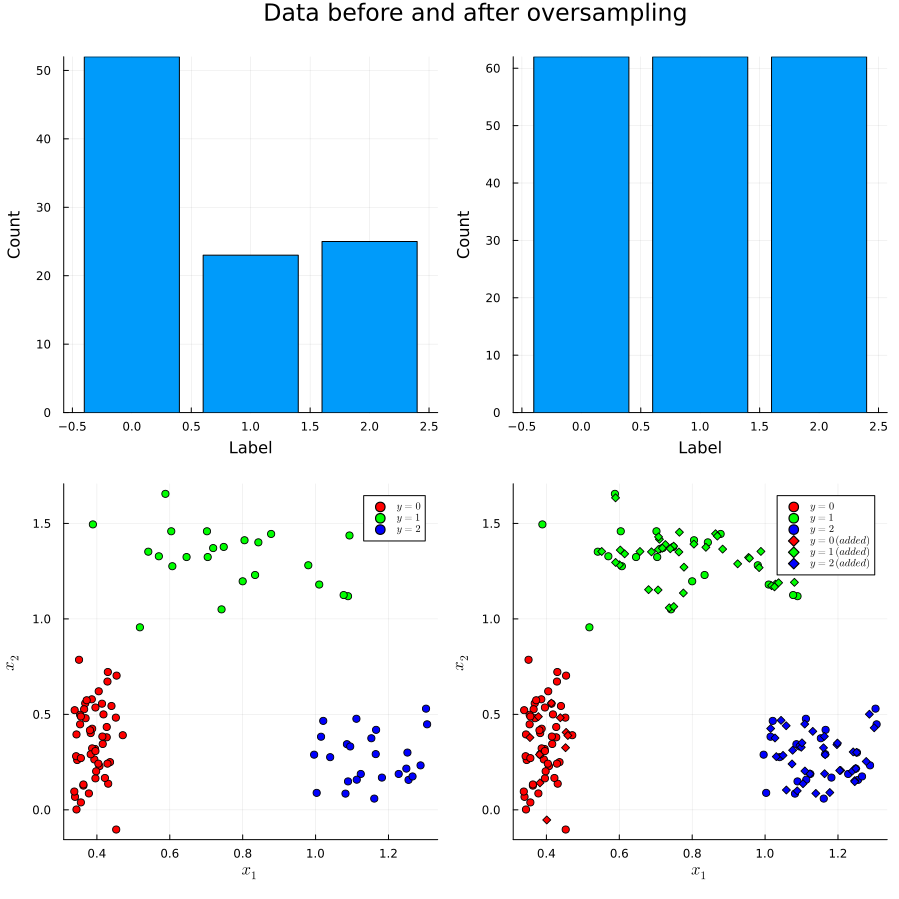

In [9]:
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, yover, X, Xover)